In [3]:
import pandas as pd

df = pd.read_parquet("reduced.parquet", engine="pyarrow")
df.head()

,cg13856810,cg06060874,cg03126058,cg19560758,cg04908588,cg20822990,cg01713950,cg22512670,cg25410668,cg12667125,...,cg05156137,cg02316713,cg26921612,cg18448426,cg08415592,age_years,source,plate,gender,ethnicity
SampleID,,,,,,,,,,,,,,,,,,,,,
"""GSM989827""",0.680305,0.592443,0.744047,0.237876,0.258552,0.306689,0.666278,0.520373,0.555612,0.583663,...,0.337838,0.317046,0.364555,0.759486,0.214572,67,UCSD,1,F,Caucasian - European
"""GSM989828""",0.608048,0.413230,0.644831,0.246561,0.191942,0.259752,0.616672,0.450366,0.580080,0.545516,...,0.269273,0.260636,0.320464,0.634557,0.146146,89,UCSD,1,F,Caucasian - European
"""GSM989829""",0.654993,0.566854,0.744626,0.267622,0.217094,0.332134,0.679804,0.526571,0.527759,0.641327,...,0.303068,0.333736,0.366828,0.730716,0.212962,66,UCSD,1,F,Caucasian - European
"""GSM989830""",0.677207,0.728849,0.827048,0.238636,0.246347,0.314241,0.668149,0.518035,0.593645,0.582638,...,0.298308,0.300084,0.354694,0.743130,0.226311,64,UCSD,1,F,Caucasian - European
"""GSM989831""",0.715584,0.527600,0.807100,0.215846,0.273770,0.305581,0.689499,0.522688,0.542025,0.654740,...,0.232456,0.332636,0.363529,0.735887,0.284690,62,UCSD,1,F,Caucasian - European


Random Forest MAE: 4.862424242424243
Random Forest R²: 0.8466436487799828


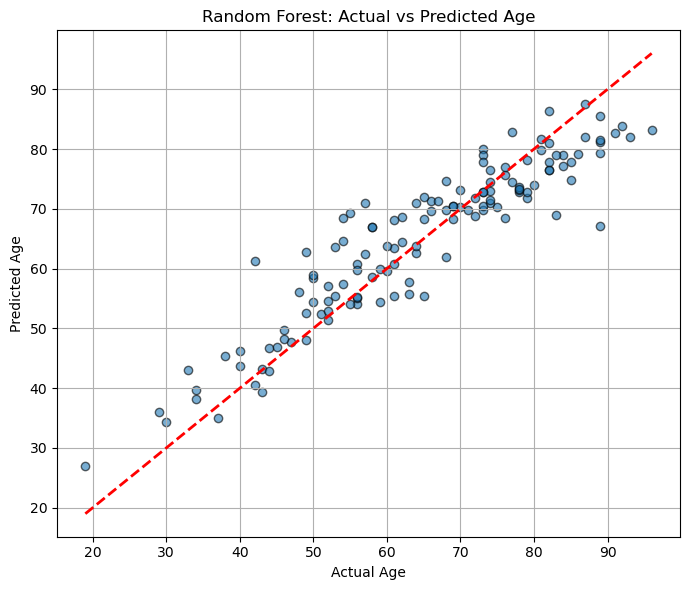

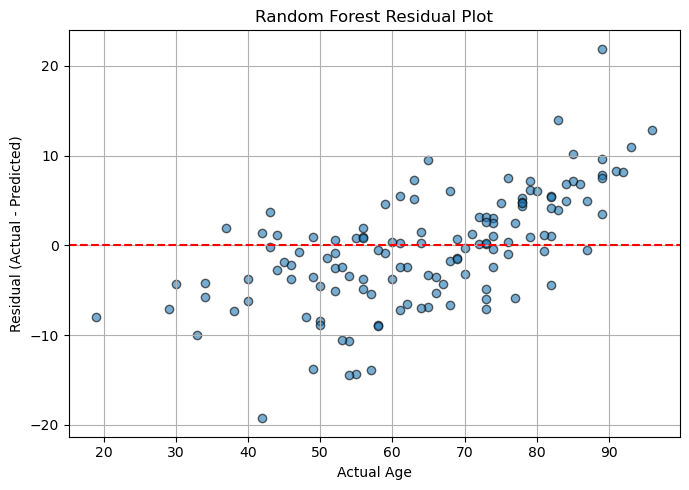

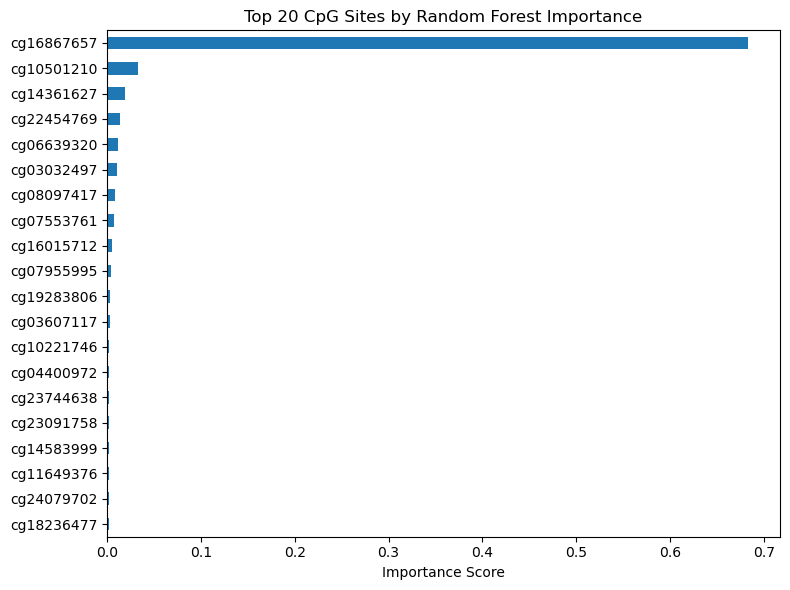

XGBoost MAE: 4.921728134155273
XGBoost R²: 0.8471335768699646


KeyboardInterrupt: 

In [4]:
# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score

# --- Load Data ---
df = pd.read_parquet("reduced.parquet", engine="pyarrow")

# --- Prepare Features & Target ---
columns_to_drop = ['age_years', 'source', 'plate', 'gender', 'ethnicity']
X = df.drop(columns=columns_to_drop)
y = df['age_years']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Random Forest ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

# Plot Actual vs Predicted
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Random Forest: Actual vs Predicted Age')
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual Plot
residuals = y_test - y_pred_rf
plt.figure(figsize=(7, 5))
plt.scatter(y_test, residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Age')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Random Forest Residual Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Feature Importance (Random Forest) ---
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(20).plot(kind='barh', figsize=(8,6), title='Top 20 CpG Sites by Random Forest Importance')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- XGBoost ---
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(x_train, y_train)
y_pred_xgb = xgb.predict(x_test)

print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))

# --- ElasticNet ---
enet = ElasticNetCV(cv=5, random_state=42, 
                    l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
                    max_iter=10000)
enet.fit(x_train, y_train)
y_pred_enet = enet.predict(x_test)

print(f"ElasticNet MAE: {mean_absolute_error(y_test, y_pred_enet):.2f}")
print(f"ElasticNet R² Score: {r2_score(y_test, y_pred_enet):.2f}")

# Plot ElasticNet Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_enet, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('ElasticNet: Predicted vs Actual Age')
plt.grid(True)
plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load & Prepare Data ---
df = pd.read_parquet("reduced.parquet", engine="pyarrow")
columns_to_drop = ['age_years', 'source', 'plate', 'gender', 'ethnicity']
X = df.drop(columns=columns_to_drop)
y = df['age_years']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Evaluation Tracker ---
results_df = pd.DataFrame(columns=["Model", "MAE", "RMSE", "R2"])

# --- Reusable Evaluation Function ---
def evaluate_model(name, model, x_train, y_train, x_test, y_test, results_df):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)  # no squared argument here
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results_df.loc[len(results_df)] = [name, mae, rmse, r2]
    return results_df, y_pred

# --- Train & Evaluate Models ---
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
results_df, y_pred_rf = evaluate_model("Random Forest", rf, x_train, y_train, x_test, y_test, results_df)

# XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
results_df, y_pred_xgb = evaluate_model("XGBoost", xgb, x_train, y_train, x_test, y_test, results_df)

# ElasticNetCV (faster with fewer l1_ratio and cv folds)
enet = ElasticNetCV(cv=3, random_state=42, 
                   l1_ratio=[0.1, 0.5, 1.0],  # fewer values for speed
                   max_iter=5000)
results_df, y_pred_enet = evaluate_model("ElasticNetCV", enet, x_train, y_train, x_test, y_test, results_df)

# --- Display Results ---
print(results_df)


           Model       MAE      RMSE        R2
0  Random Forest  4.862424  6.280817  0.846644
1        XGBoost  4.921728  6.270777  0.847134
2   ElasticNetCV  4.095827  5.541977  0.880601


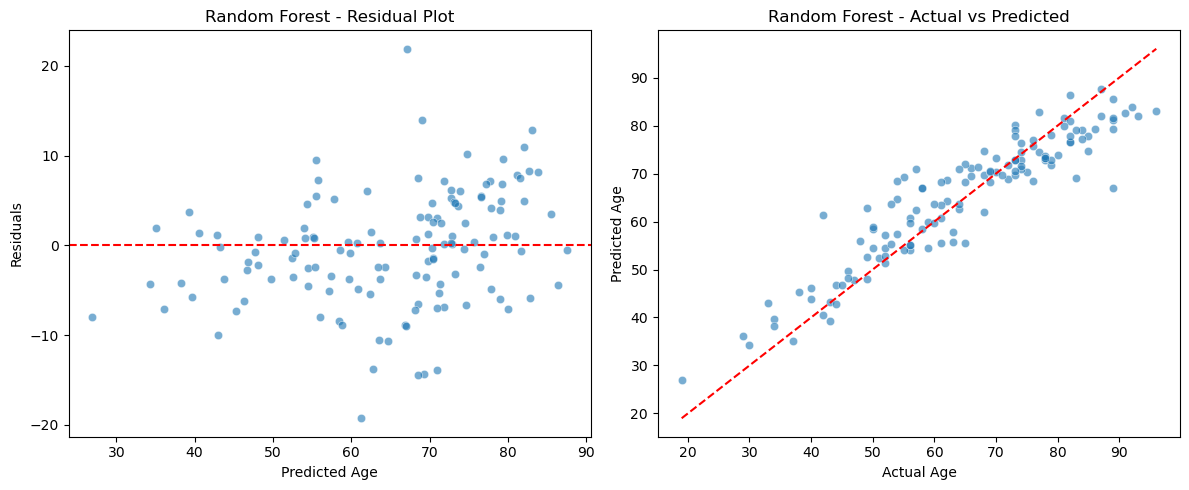

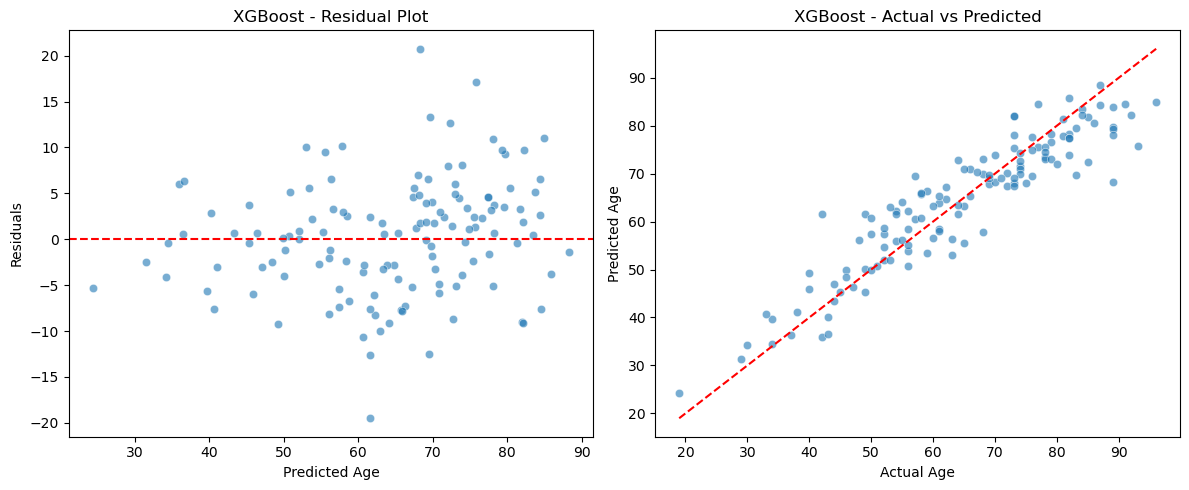

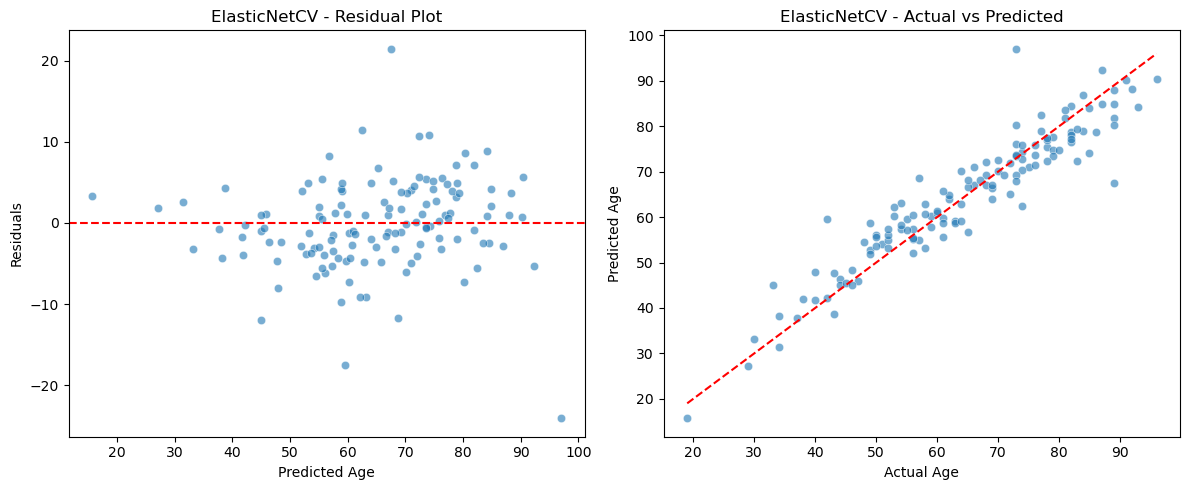

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Residual & Actual vs Predicted Plots ---
def plot_diagnostics(y_test, y_pred, model_name):
    residuals = y_test - y_pred

    plt.figure(figsize=(12, 5))

    # Residual Plot
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{model_name} - Residual Plot')
    plt.xlabel('Predicted Age')
    plt.ylabel('Residuals')

    # Actual vs Predicted Plot
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')

    plt.tight_layout()
    plt.show()

# --- Plot for Each Model ---
plot_diagnostics(y_test, y_pred_rf, "Random Forest")
plot_diagnostics(y_test, y_pred_xgb, "XGBoost")
plot_diagnostics(y_test, y_pred_enet, "ElasticNetCV")


In [24]:
# --- Create Feature Importance DataFrame ---
import numpy as np

# Get all feature names
feature_names = X.columns.tolist()

# Random Forest
rf_importance = rf.feature_importances_
rf_df = pd.DataFrame({
    "random_forest_Feature": feature_names,
    "random_forest_importance_score": rf_importance
}).sort_values(by="random_forest_importance_score", ascending=False).head(20).reset_index(drop=True)

# XGBoost
xgb_importance = xgb.feature_importances_
xgb_df = pd.DataFrame({
    "xg_boost_Feature": feature_names,
    "xg_boost_importance_score": xgb_importance
}).sort_values(by="xg_boost_importance_score", ascending=False).head(20).reset_index(drop=True)

# ElasticNetCV
enet_coef = enet.coef_
enet_df = pd.DataFrame({
    "elasticnetcv_Feature": feature_names,
    "elasticnetcv_Coefficient": enet_coef
})
enet_df = enet_df[enet_df["elasticnetcv_Coefficient"] != 0]  # Drop zero weights
enet_df["abs_coeff"] = np.abs(enet_df["elasticnetcv_Coefficient"])
enet_df = enet_df.sort_values(by="abs_coeff", ascending=False).head(20).drop(columns=["abs_coeff"]).reset_index(drop=True)

# --- Merge Top 20 by Rank ---
feature_rank_df = pd.concat([
    rf_df,
    xgb_df,
    enet_df
], axis=1)

# --- Add Rank Column ---
feature_rank_df.insert(0, "Rank", feature_rank_df.index + 1)

# --- Display the Comparison Table ---
feature_rank_df.head(10)

,Rank,random_forest_Feature,random_forest_importance_score,xg_boost_Feature,xg_boost_importance_score,elasticnetcv_Feature,elasticnetcv_Coefficient
0,1,cg16867657,0.683200,cg16867657,0.432262,cg16867657,13.261134
1,2,cg10501210,0.032405,cg10501210,0.050545,cg10501210,-11.497606
2,3,cg14361627,0.018857,cg06639320,0.035487,cg14361627,9.548973
3,4,cg22454769,0.013454,cg14361627,0.024364,cg07955995,8.589273
4,5,cg06639320,0.011990,cg03032497,0.020138,cg22454769,7.749061
5,6,cg03032497,0.009946,cg05991454,0.019298,cg08097417,7.676333
6,7,cg08097417,0.007794,cg17471102,0.016269,cg26290632,7.473508
7,8,cg07553761,0.007487,cg09809672,0.013466,cg01820962,-7.379343
8,9,cg16015712,0.005185,cg23500537,0.013203,cg17621438,-7.144731
9,10,cg07955995,0.003956,cg11649376,0.012620,cg06639320,6.702846


In [14]:
feature_rank_df.columns

Index(['Rank', 'random_forest_Feature', 'random_forest_importance_score',
       'xg_boost_Feature', 'xg_boost_importance_score', 'elasticnetcv_Feature',
       'elasticnetcv_Coefficient'],
      dtype='object')

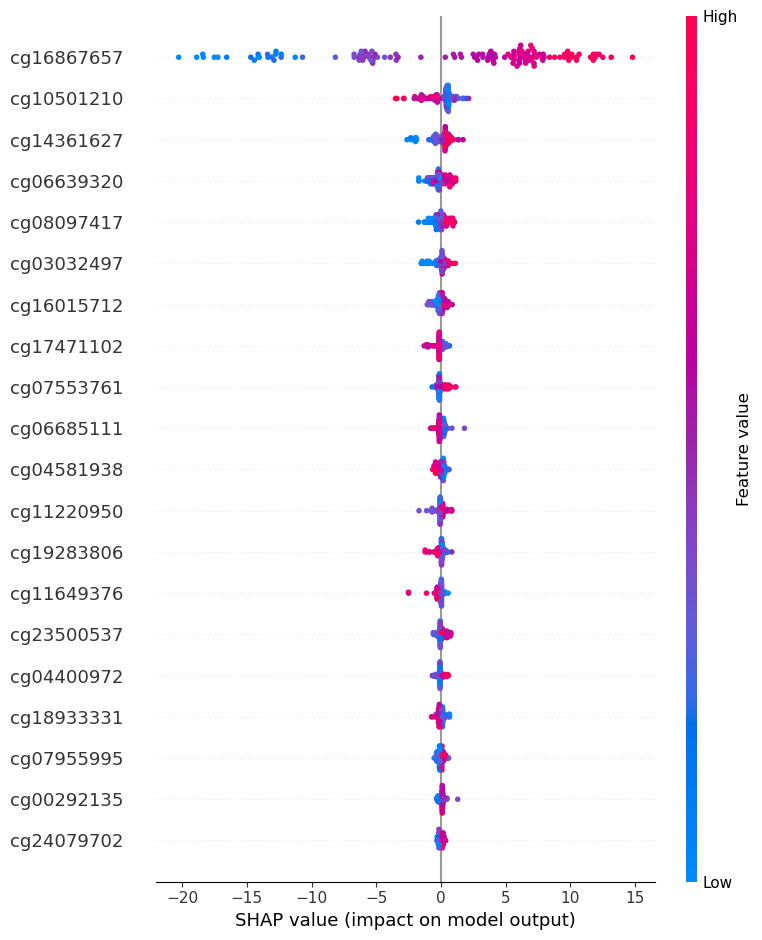

In [18]:
import shap

# Example for XGBoost
explainer = shap.Explainer(xgb)
shap_values = explainer(x_test)

# Summary Plot
shap.summary_plot(shap_values, x_test)


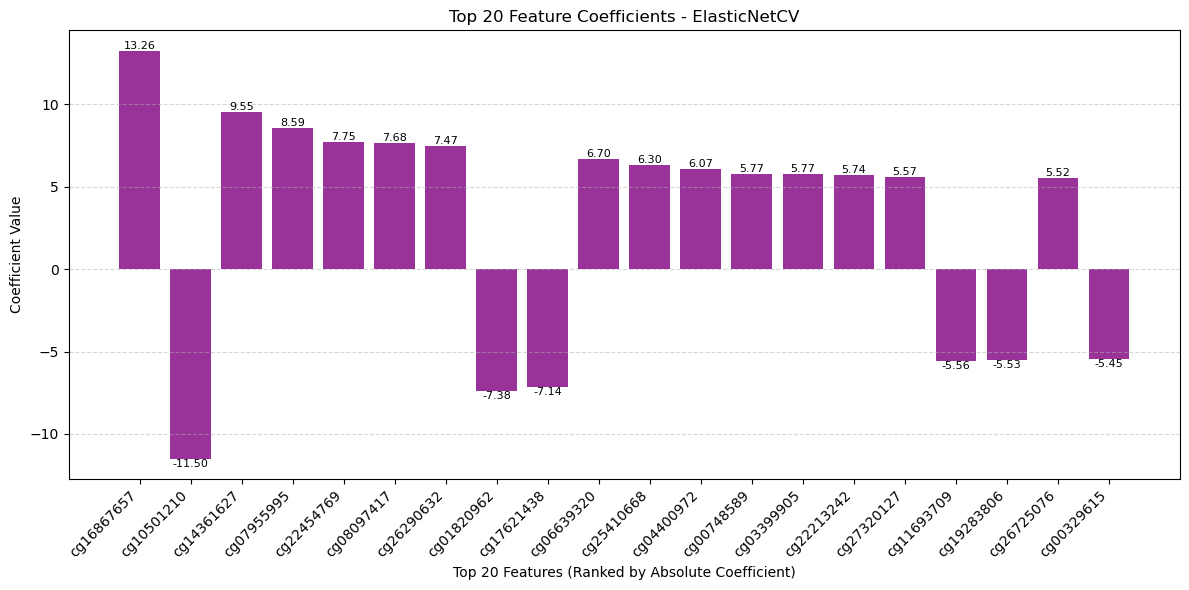

In [43]:
coef = pd.Series(enet.coef_, index=x_train.columns)

# Get top 20 features by absolute coefficient value
top_20 = coef.abs().sort_values(ascending=False).head(20).index
top_coef = coef[top_20]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(top_coef.index, top_coef.values, color='purple', alpha=0.8)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval,
             f'{yval:.2f}', ha='center',
             va='bottom' if yval >= 0 else 'top',
             fontsize=8)

# Format plot
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlabel('Top 20 Features (Ranked by Absolute Coefficient)')
plt.ylabel('Coefficient Value')
plt.title('Top 20 Feature Coefficients - ElasticNetCV')
plt.tight_layout()
plt.show()

In [19]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(rf, x_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm.importances_mean.argsort()[::-1]

for i in sorted_idx[:10]:
    print(f"{X.columns[i]}: {perm.importances_mean[i]:.4f}")


cg16867657: 0.5569
cg14361627: 0.0129
cg10501210: 0.0106
cg08097417: 0.0059
cg16015712: 0.0053
cg06639320: 0.0048
cg07553761: 0.0041
cg03032497: 0.0040
cg22454769: 0.0031
cg03399905: 0.0029


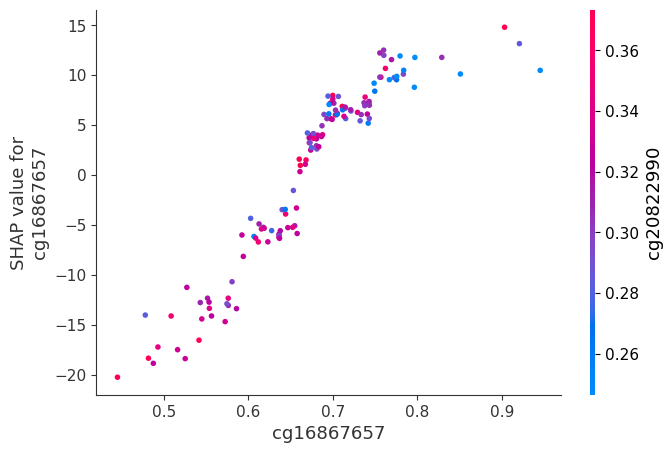

In [21]:
shap.dependence_plot("cg16867657", shap_values.values, x_test)


# Male | Female comparison

In [38]:
male_reduced = pd.read_parquet('male_reduced.parquet', engine='pyarrow')  # or engine='fastparquet'
female_reduced = pd.read_parquet('female_reduced.parquet', engine='pyarrow')  # or engine='fastparquet'

In [39]:
male_reduced.shape,female_reduced.shape

((318, 531), (338, 414))

In [40]:
#This should be final

# === Helper function to train model and extract coefficients ===
def train_and_get_top20_coefs(df, gender_label):
    columns_to_drop = ['age_years', 'source', 'plate', 'gender', 'ethnicity']
    X = df.drop(columns=columns_to_drop)
    y = df['age_years']

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train ElasticNetCV
    model = ElasticNetCV(
        cv=5,
        random_state=42,
        l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
        max_iter=10000
    )
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{gender_label} ElasticNet MAE: {mae:.2f}")
    print(f"{gender_label} ElasticNet R² Score: {r2:.2f}")

    # Plot actual vs predicted
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title(f'{gender_label} ElasticNet: Predicted vs Actual Age')
    plt.grid(True)
    plt.show()

    # Get feature names and coefficients
    feature_names = X_train.columns
    coefs = model.coef_

    # Create dataframe of features and coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        f'{gender_label}_Coefficient': coefs
    })

    # Add absolute coefficient for importance
    coef_df[f'Abs_{gender_label}_Coefficient'] = coef_df[f'{gender_label}_Coefficient'].abs()

    # Get top 20
    top20 = coef_df.sort_values(by=f'Abs_{gender_label}_Coefficient', ascending=False).head(20)
    top20 = top20[['Feature', f'{gender_label}_Coefficient']].reset_index(drop=True)

    return top20


Male ElasticNet MAE: 3.02
Male ElasticNet R² Score: 0.94


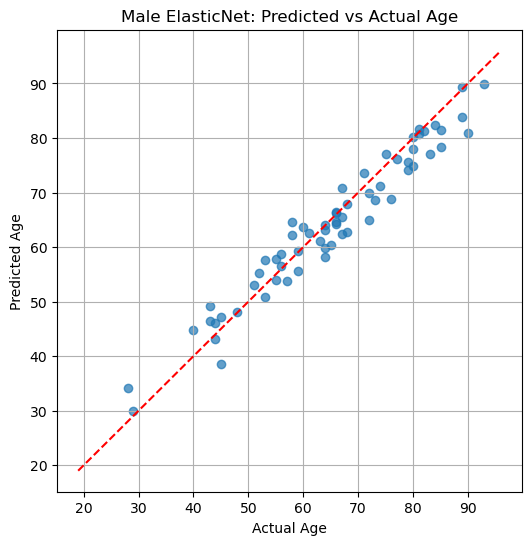


Female ElasticNet MAE: 3.83
Female ElasticNet R² Score: 0.83


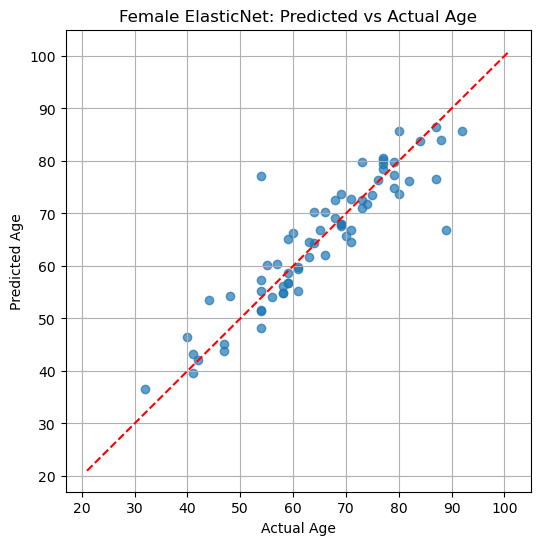


Top 20 Male & Female Features (by absolute coefficient):
     Male_Feature  Male_Coefficient Female_Feature  Female_Coefficient
Rank                                                                  
1      cg16867657         11.895383     cg16867657           13.983553
2      cg14361627          9.563304     cg11847992          -10.584663
3      cg04826368          8.956538     cg14361627            9.137636
4      cg10501210         -8.821103     cg25410668            8.867029
5      cg04875128          8.537240     cg22016779           -8.191081
6      cg08097417          7.810729     cg10501210           -8.184267
7      cg14209784         -7.763042     cg04738109            7.402233
8      cg01820962         -7.704424     cg18933331           -7.112302
9      cg18738190          7.599086     cg00573770           -7.024673
10     cg14692377          7.426877     cg22454769            6.811965
11     cg18473521          7.195265     cg20426994            6.791409
12     cg17110586  

In [41]:
# === Run for male and female ===
top20_male = train_and_get_top20_coefs(male_reduced, "Male")
top20_male.columns = ['Male_Feature', 'Male_Coefficient']

top20_female = train_and_get_top20_coefs(female_reduced, "Female")
top20_female.columns = ['Female_Feature', 'Female_Coefficient']

# === Combine into single DataFrame side-by-side ===
top20_combined = pd.concat([top20_male, top20_female], axis=1)
top20_combined.index = top20_combined.index + 1
top20_combined.index.name = 'Rank'

# === Display final combined table ===
print("\nTop 20 Male & Female Features (by absolute coefficient):")
print(top20_combined)

# === Optional: Save to CSV ===
# top20_combined.to_csv('top20_male_female_features.csv', index=True)


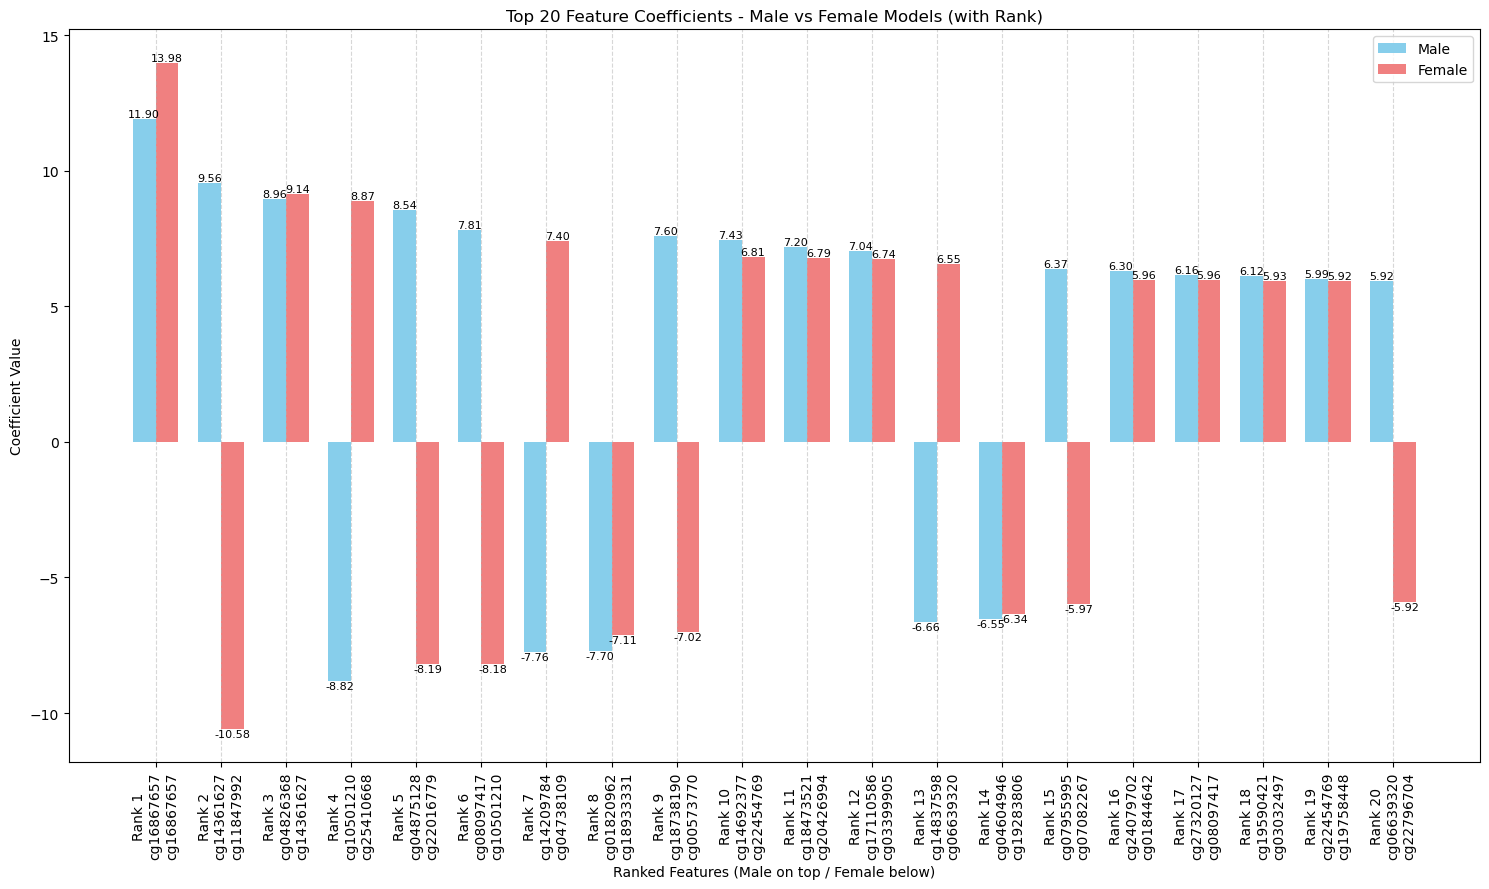

In [42]:
# Create x positions
x = np.arange(len(top20_combined))
width = 0.35

plt.figure(figsize=(15, 9))

# Plot bars
bars_male = plt.bar(x - width/2, top20_combined['Male_Coefficient'], width, label='Male', color='skyblue')
bars_female = plt.bar(x + width/2, top20_combined['Female_Coefficient'], width, label='Female', color='lightcoral')

# Custom x-tick labels: Rank + Male + Female
xtick_labels = [
    f"Rank {i+1}\n{m_feat}\n{f_feat}"
    for i, (m_feat, f_feat) in enumerate(zip(top20_combined['Male_Feature'], top20_combined['Female_Feature']))
]
plt.xticks(x, xtick_labels, rotation=90)

# Add value labels on each bar
for bar in bars_male:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval,
             f'{yval:.2f}', ha='center', va='bottom' if yval >= 0 else 'top', fontsize=8)

for bar in bars_female:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval,
             f'{yval:.2f}', ha='center', va='bottom' if yval >= 0 else 'top', fontsize=8)
plt.grid(axis='x', linestyle='--', alpha=0.5)
# Labels and formatting
plt.xlabel('Ranked Features (Male on top / Female below)')
plt.ylabel('Coefficient Value')
plt.title('Top 20 Feature Coefficients - Male vs Female Models (with Rank)')
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
path = r"C:\Users\pacma\Downloads\HM450.hg38.manifest.tsv\HM450.hg38.manifest.tsv"
df = pd.read_csv(path, sep="\t")


In [8]:
df.head()

,CpG_chrm,CpG_beg,CpG_end,address_A,address_B,target,nextBase,channel,Probe_ID,mapFlag_A,...,mapFlag_B,mapChrm_B,mapPos_B,mapQ_B,mapCigar_B,AlleleB_ProbeSeq,mapNM_B,mapAS_B,mapYD_B,type
0,chr16,53434199.0,53434201.0,14782418,NaN,CG,NaN,NaN,cg00000029,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,II
1,chr3,37417714.0,37417716.0,12709357,NaN,CG,NaN,NaN,cg00000108,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,II
2,chr3,172198246.0,172198248.0,59755374,NaN,CG,NaN,NaN,cg00000109,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,II
3,chr1,90729116.0,90729118.0,12637463,NaN,CG,NaN,NaN,cg00000165,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,II
4,chr8,42405775.0,42405777.0,12649348,NaN,CG,NaN,NaN,cg00000236,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,II


In [9]:
df.shape

(486427, 28)